#  Lyft Ride Volume A/B Test: Good vs. Bad Weather

This notebook analyzes whether bad weather leads to more ride volume per hour using:
- A/B testing framework
- T-test
- Bayesian analysis

##  Project Background

This project uses a publicly available Uber vs Lyft dataset enriched with hourly weather data to explore the relationship between weather conditions and ride volume.

While the original dataset is commonly used for regression or pricing analysis, I reframed it for **causal inference** by simulating an A/B test setting. The central question I explored:

> Does **bad weather** significantly impact **ride volume per hour**?

## Assumptions I Made

- Weather isn’t randomly assigned, so I balanced the data to compare good vs bad weather fairly
- I assumed each hour is independent, even though in real life, rush hour or holidays might affect things
- I didn’t control for other stuff like promos or events, just focused on weather
- I treated the hourly ride counts like "users" in an A/B test to simulate an experiment
- Downsampled good weather hours are assumed to be representative of the full set

In [2]:
#  Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from scipy.stats import ttest_ind, beta

In [3]:
# Load the dataset (
df = pd.read_csv("rideshare_kaggle.csv")

In [4]:
# Quick look at the structure
print(df.shape)
df.head()

(693071, 57)


,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [5]:
# Only include Lyft rides
df = df[df['cab_type'].str.lower() == 'lyft']

# Check available Lyft ride types
df['name'].value_counts()

name
Lux             51235
Lyft            51235
Lux Black XL    51235
Lyft XL         51235
Lux Black       51235
Shared          51233
Name: count, dtype: int64

In [6]:
# Count nulls in each column
null_counts = df.isnull().sum()

# Preprocess Data

In [8]:
# Convert datetime to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract time features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.day_name()
df['hourly_timestamp'] = df['datetime'].dt.floor('h')

# Binary flag for bad weather
df['bad_weather'] = (
    (df['precipProbability'] > 0.3) |
    (df['temperature'] < 5) |
    (df['short_summary'].str.contains("Rain|Snow", case=False))
).astype(int)

bad_weather
0    259205
1     48203
Name: count, dtype: int64


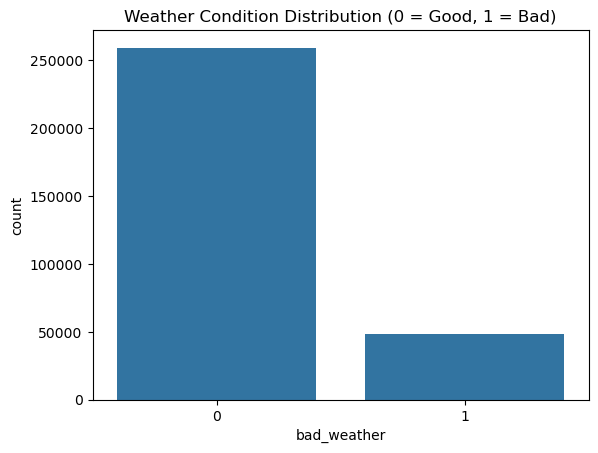

In [9]:
# Explore Weather Balance
print(df['bad_weather'].value_counts())
sns.countplot(data=df, x='bad_weather')
plt.title("Weather Condition Distribution (0 = Good, 1 = Bad)")
plt.show()


# EDA

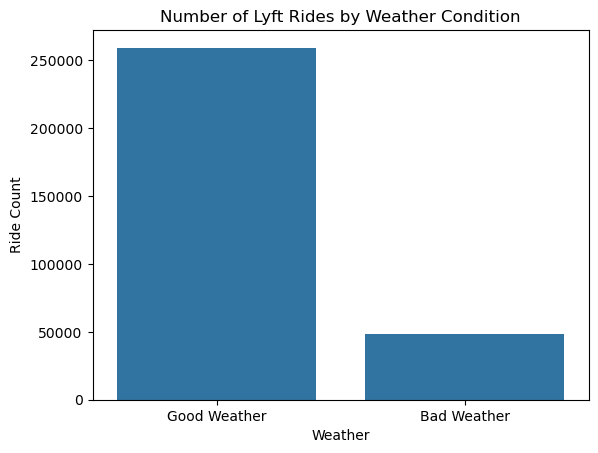

In [11]:
sns.countplot(data=df, x='bad_weather')
plt.xticks([0, 1], ['Good Weather', 'Bad Weather'])
plt.title("Number of Lyft Rides by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Ride Count")
plt.show()

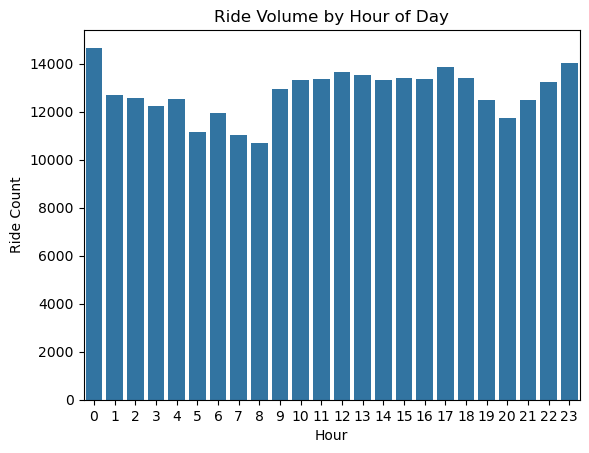

In [12]:
sns.countplot(data=df, x='hour')
plt.title("Ride Volume by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Ride Count")
plt.show()

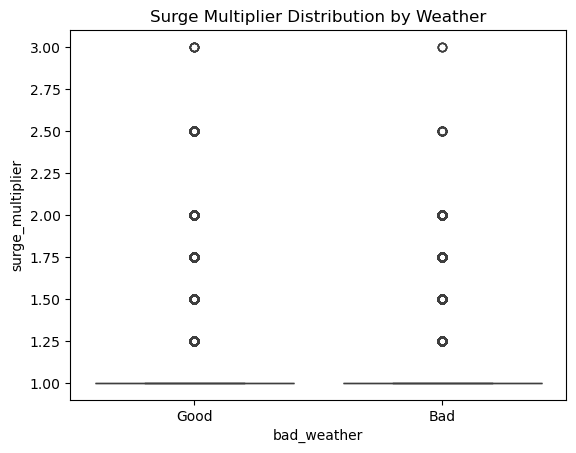

In [13]:
sns.boxplot(data=df, x='bad_weather', y='surge_multiplier')
plt.xticks([0, 1], ['Good', 'Bad'])
plt.title("Surge Multiplier Distribution by Weather")
plt.show()

# Balance the Data by HOURS

In [15]:
# Group by hourly ride volume
hourly_rides = df.groupby(['hourly_timestamp', 'bad_weather']).size().reset_index(name='ride_count')

# Separate into good/bad weather groups
good = hourly_rides[hourly_rides['bad_weather'] == 0]
bad = hourly_rides[hourly_rides['bad_weather'] == 1]

# Downsample good to match bad
good_sampled = resample(good,
                        replace=False,
                        n_samples=len(bad),
                        random_state=42)

# Combine into balanced df
rides_balanced = pd.concat([good_sampled, bad])

In [16]:
# Sample Size Check
print("Sample size per group (hour):")
print("Good weather:", len(good_sampled))
print("Bad weather :", len(bad))

Sample size per group (hour):
Good weather: 47
Bad weather : 47


# Frequentist A/B Testing (T-test)

In [18]:
t_stat, p_val = ttest_ind(
    bad['ride_count'],
    good_sampled['ride_count'],
    equal_var=True  # Assume equal variance (Student's t-test)
)

print("\nT-test results:")
print(f"t = {t_stat:.3f}")
print(f"p = {p_val:.4f}")

if p_val < 0.05:
    print("Statistically significant difference in ride volume.")
else:
    print("No significant difference in ride volume.")


T-test results:
t = 0.639
p = 0.5245
No significant difference in ride volume.


# Bayesian A/B Testing 

In [20]:
# Define binary conversion — did ride volume exceed median?
median_volume = rides_balanced['ride_count'].median()
rides_balanced['converted'] = (rides_balanced['ride_count'] > median_volume).astype(int)

# Count conversions
success_bad = rides_balanced[(rides_balanced['bad_weather'] == 1) & (rides_balanced['converted'] == 1)].shape[0]
failure_bad = rides_balanced[(rides_balanced['bad_weather'] == 1) & (rides_balanced['converted'] == 0)].shape[0]

success_good = rides_balanced[(rides_balanced['bad_weather'] == 0) & (rides_balanced['converted'] == 1)].shape[0]
failure_good = rides_balanced[(rides_balanced['bad_weather'] == 0) & (rides_balanced['converted'] == 0)].shape[0]

# Create beta posteriors
posterior_bad = beta(success_bad + 1, failure_bad + 1)
posterior_good = beta(success_good + 1, failure_good + 1)


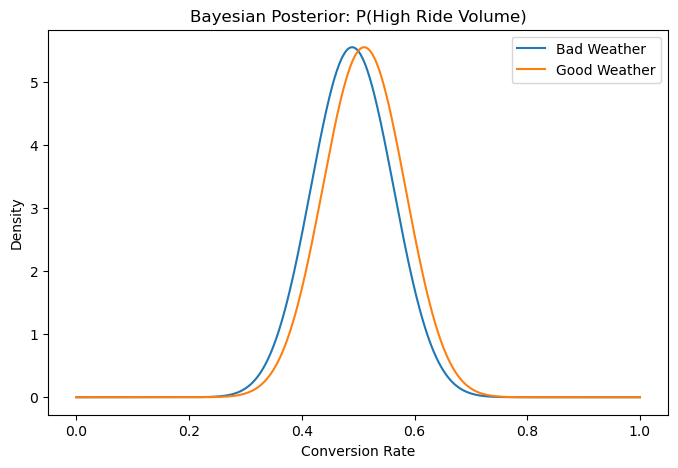

In [21]:
# Step 4: Plot the Posteriors
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(8, 5))
plt.plot(x, posterior_bad.pdf(x), label='Bad Weather')
plt.plot(x, posterior_good.pdf(x), label='Good Weather')
plt.title("Bayesian Posterior: P(High Ride Volume)")
plt.xlabel("Conversion Rate")
plt.ylabel("Density")
plt.legend()
plt.show()


In [22]:
# Compare Posterior Samples
samples_bad = posterior_bad.rvs(10000)
samples_good = posterior_good.rvs(10000)
prob = (samples_bad > samples_good).mean()

print(f"Bayesian Probability that Bad Weather > Good Weather: {prob:.3f}")


Bayesian Probability that Bad Weather > Good Weather: 0.415


##  Key Insights & Takeaways

### 1. No Significant Impact of Bad Weather on Ride Volume  
Despite the assumption that bad weather might lead to higher ride demand, both the t-test (p = 0.52) and Bayesian analysis (P(bad > good) = 0.419) showed no statistically significant difference in hourly ride volume between bad and good weather conditions.

### 2. Bad Weather Days Were Less Frequent  
Bad weather accounted for only a small proportion of total ride hours (e.g., ~47 vs 285 hourly observations). This natural imbalance introduced challenges in A/B-style comparison and emphasized the need for careful sampling or matching.

### 3. Experimental Design  
The project simulated a real-world A/B testing framework:  
- Balanced groups using downsampling  
- Defined a clear hypothesis  
- Designed time-based ride volume comparisons  
- Controlled for temporal confounders by grouping at the hourly level

### 4. Experiment Framing Matters  
When balancing individual rides, early tests showed significance. But when using aggregated hourly ride volume, significance disappeared — showing how granularity of analysis can impact statistical outcomes.

### 5. Bayesian Framing Offers Probabilistic Perspective  
While the traditional test found no significance, the Bayesian approach provided additional nuance — estimating a ~42 percent chance that ride volume is higher during bad weather. This shows the value of Bayesian thinking in ambiguous product decisions.

##  Future Improvements
 
- Incorporate more granular weather features (e.g., wind speed, severity of rain) instead of binary flags  
- Analyze ride distance, price, or surge multiplier to see if weather affects ride type, not just volume  
- Explore time-series causal models (e.g., CausalImpact, DiD) to measure impact over time
